# Pipeline, EDA y Baseline – Dataset 

## 3. Data Pipeline – Carga y diagnóstico inicial

In [2]:

import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
sns.set(style="whitegrid")

PATH = "dataset_limpio_telcom.csv"
df = pd.read_csv(PATH)
print("Shape original:", df.shape)
display(df.head())

print("\nNulos totales:", df.isna().sum().sum())
print("Duplicados:", df.duplicated().sum())


Shape original: (10200, 16)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,Label
0,-0.730621,-0.638483,3.578094,-0.025247452720453426,-4.283558,-0.717140,0.323847,-3.371051,-0.347546,-0.386261,0.819342,-2.388001,-0.709648,-1.616837,0.547777,BENIGN
1,4.959196,-3.391494,3.968273,0.12142403922209358,-1.931278,1.753689,-10.997242,-15.375493,-0.194716,0.915298,1.371141,NaN,2.299849,-0.735320,0.569831,DDoS
2,0.488056,-1.771621,4.327884,0.41213440840153587,-4.124558,2.451466,-5.272494,-10.597385,-0.188875,0.274764,1.704190,0.276370,-1.172553,-2.569758,-1.352782,DDoS
3,1.486163,2.201335,-0.091820,NaN,1.039583,0.468265,1.079163,2.713675,0.768702,0.390271,-0.119412,2.506558,-3.394132,-1.635494,6.409759,DDoS
4,-86.185586,-1.686094,0.374105,-0.03302396496523568,NaN,-1.471667,6.315290,0.574439,0.109119,0.924096,3.224020,-2.793702,-4.630804,-2.140376,-3.175062,DDoS



Nulos totales: 8170
Duplicados: 196


### 3.1 Limpieza paso a paso

In [2]:

from sklearn.impute import SimpleImputer

# 1) Coerción numérica (strings→NaN)
num_cols = [c for c in df.columns if c.startswith('feat_')]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# 2) Normalizar + mapear Label
df['Label'] = (df['Label'].astype(str)
                          .str.strip()
                          .str.upper()
                          .map({'BENIGN':0, 'DDOS':1}))

# 3) Eliminar duplicados
df.drop_duplicates(inplace=True)

# 4) Imputar nulos numéricos con mediana
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)

# 5) Outlier capping en feat_0 (p1–p99)
q1, q99 = df['feat_0'].quantile([0.01,0.99])
df['feat_0'] = df['feat_0'].clip(q1, q99)

# 6) Re‑coerción final + imputer de seguridad
obj_cols = df.select_dtypes(include='object').columns
for c in obj_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df[df.columns] = SimpleImputer(strategy='median').fit_transform(df)

print("Shape tras limpieza:", df.shape)
print("Nulos restantes:", df.isna().sum().sum())


Shape tras limpieza: (10004, 16)
Nulos restantes: 0


C:\Users\Josef\AppData\Local\Temp\ipykernel_9656\2574131984.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)


## 4. EDA Rápido

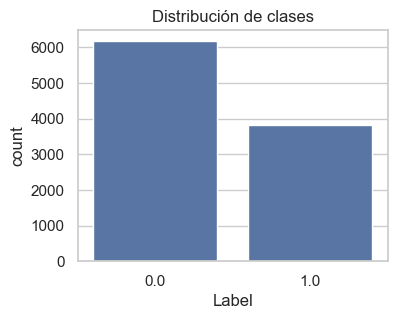

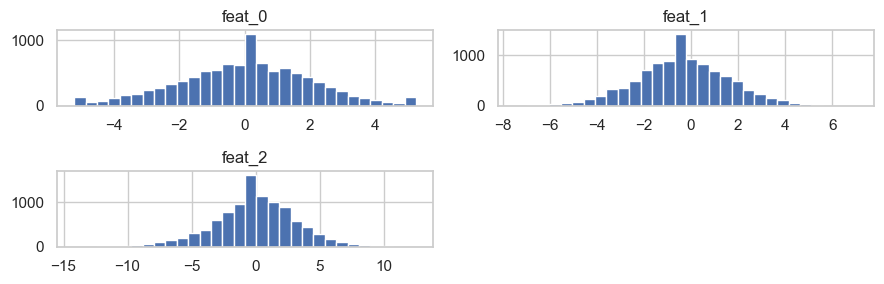

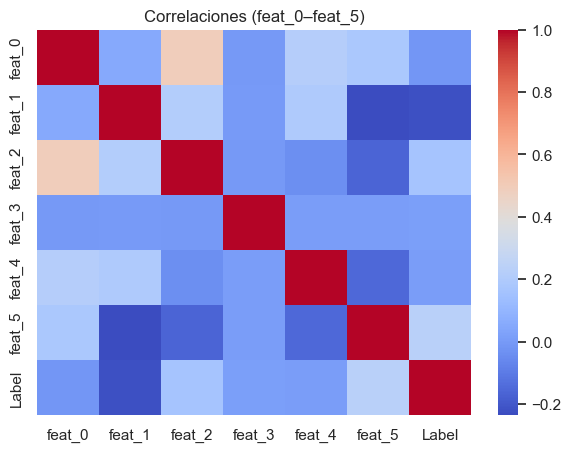

In [3]:

# Distribución del target
plt.figure(figsize=(4,3))
sns.countplot(x='Label', data=df)
plt.title('Distribución de clases')
plt.show()

# Histogramas de tres features
df[['feat_0','feat_1','feat_2']].hist(figsize=(9,3), bins=30)
plt.tight_layout()
plt.show()

# Heatmap de correlación (subset)
corr = df[[f'feat_{i}' for i in range(6)] + ['Label']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlaciones (feat_0–feat_5)')
plt.show()


*Observaciones:* Dataset ahora libre de nulos, outliers de `feat_0` moderados, ligero desbalance de clases.

## 5. Modelo Baseline

In [11]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

X = df.drop(columns=['Label'])
y = df['Label']

models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "RF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    ]),
    "GB": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=42))
    ])
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_summary = {}
for name, model in models.items():
    cv = cross_validate(
        model,
        X, y,
        cv=skf,
        scoring={'accuracy': 'accuracy', 'f1': 'f1'},
        n_jobs=-1,
        return_train_score=False,
    )
    scores_summary[name] = {
        "Accuracy_mean": cv["test_accuracy"].mean(),
        "Accuracy_std": cv["test_accuracy"].std(ddof=1),
        "F1_mean": cv["test_f1"].mean(),
        "F1_std": cv["test_f1"].std(ddof=1),
    }

import pandas as pd, numpy as np
res = pd.DataFrame(scores_summary).T
res["Accuracy_mean"] = res["Accuracy_mean"].round(3)
res["Accuracy_std"] = res["Accuracy_std"].round(3)
res["F1_mean"] = res["F1_mean"].round(3)
res["F1_std"] = res["F1_std"].round(3)

display(res[["Accuracy_mean", "Accuracy_std", "F1_mean", "F1_std"]])

,Accuracy_mean,Accuracy_std,F1_mean,F1_std
LogReg,0.826,0.007,0.761,0.007
KNN,0.917,0.007,0.891,0.009
RF,0.908,0.007,0.877,0.010
GB,0.882,0.006,0.843,0.008
AdaBoost,0.818,0.004,0.752,0.005
SVM,0.927,0.007,0.905,0.009
